In [2]:
import os
import pandas as pd
import csv
import numpy as np
import ast
from tqdm import notebook
import math
import json
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import statistics
warnings.filterwarnings('ignore')

In [3]:
def load_scores(f):
  df = pd.read_csv(f)
  df['Scores'] = df['Scores'].apply(ast.literal_eval)
  df['Workers'] = df['Workers'].apply(ast.literal_eval)
  df['Distortions'] = df['Distortions'].apply(ast.literal_eval)
  return df

In [1]:
df_c = load_scores('data_analysis/scores_summary_itu_clean.csv')
df_p = load_scores('data_analysis/scores_patch_summary_itu_clean.csv')
df_o = load_scores('data_analysis/scores_ORBIT_summary_itu_clean.csv')

NameError: name 'load_scores' is not defined

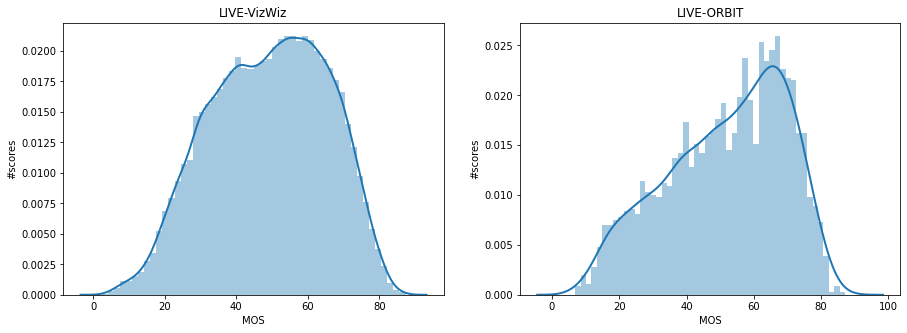

In [17]:
f, axs = plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1)
scores = np.asarray(df_c['MOS'].tolist())
x = scores[~np.isnan(scores)]
sns.distplot(x, hist=True, kde=True, bins=50, color = 'tab:blue', 
              #  hist_kws={'edgecolor':'tab:blue'},
              kde_kws={'linewidth': 2})
total = len(x)
plt.title('LIVE-VizWiz')
plt.xlabel('MOS')
plt.ylabel('#scores')

# plt.subplot(1, 3, 2)
# scores = np.asarray(df_p['MOS'].tolist())
# x = scores[~np.isnan(scores)]
# sns.distplot(x, hist=True, kde=True, bins=50, color = 'tab:blue', 
#               #  hist_kws={'edgecolor':'tab:blue'},
#               kde_kws={'linewidth': 2})
# total = len(x)
# plt.title('LIVE-VizWiz Patches')
# plt.xlabel('MOS')
# plt.ylabel('#scores')


plt.subplot(1, 2, 2)
scores = np.asarray(df_o['MOS'].tolist())
x = scores[~np.isnan(scores)]
sns.distplot(x, hist=True, kde=True, bins=50, color = 'tab:blue', 
              #  hist_kws={'edgecolor':'tab:blue'},
              kde_kws={'linewidth': 2})
total = len(x)
plt.title('LIVE-ORBIT')
plt.xlabel('MOS')
plt.ylabel('#scores')

plt.show()

In [ ]:
########## INTER_SUBJECT CONSISTENCY ###########################

In [18]:
def inter_subj(df):
    valn = 5
    N = 50
    MOS1 = []
    MOS2 = []
    # del_thresh = 1
    for i in (range(len(df))):
      scores = np.asarray(df['Scores'][i])
      l = len(scores)
      if l >= valn:
        idx = int(l/2)
        set1 = []
        set2 = []
        for j in range(N):
          np.random.shuffle(scores)
          s1 = np.mean(scores[:idx])
          s2 = np.mean(scores[idx:])
          set1.append(s1)
          set2.append(s2)
        MOS1.append(set1)
        MOS2.append(set2)
    MOS1 = np.asarray(MOS1)
    MOS2 = np.asarray(MOS2)
    srocc = []
    c = MOS1.shape
    # k = random.sample(range(c[0]), 100)
    for i in (range(c[1])):
      s1 = pd.Series(MOS1[:,i])
      s2 = pd.Series(MOS2[:,i])
      srocc.append(s1.corr(s2, method='spearman'))

    avg_srocc = np.mean(srocc)
    plt.scatter(s1, s2, s=5)
    plt.xlabel('MOS1')
    plt.ylabel('MOS2')
    plt.title('Avg SROCC: ' + str(round(avg_srocc,2)) + ' | ' +'#iters: ' + str(N) + ' | ' + '#images: ' + str(len(s1)))
    plt.show()
    # print(np.std(srocc))

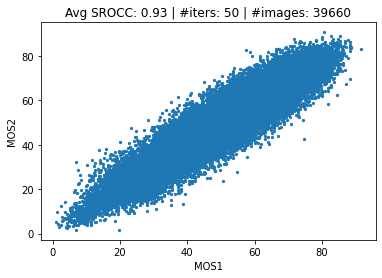

In [19]:
inter_subj(df_c)

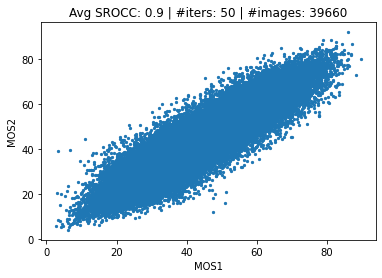

In [21]:
inter_subj(df_p)

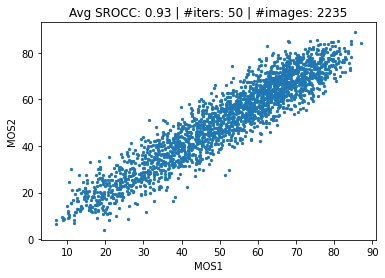

In [22]:
inter_subj(df_o)

In [23]:
df_rand = pd.DataFrame(columns=df_p.columns)
df_sal = pd.DataFrame(columns=df_p.columns)

In [24]:
patch_list = df_p.Image.tolist()

In [27]:
for i in notebook.tqdm(range(len(df_p))):
  patch = df_p['Image'][i].split('/')[1]
  if '_sal' in patch:
    df_sal = df_sal.append(pd.Series(df_p.loc[i,:]),ignore_index=True)
  else:
    df_rand = df_rand.append(pd.Series(df_p.loc[i,:]),ignore_index=True)

  0%|          | 0/39660 [00:00<?, ?it/s]

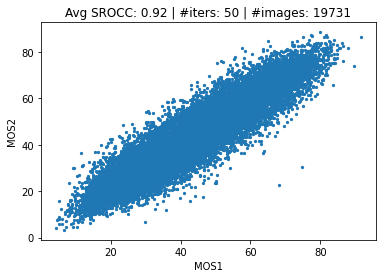

In [30]:
inter_subj(df_sal)

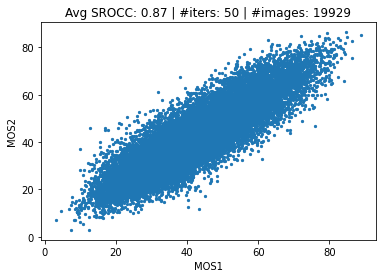

In [31]:
inter_subj(df_rand)

In [ ]:
################# INTRA_SUBJECT CONSISTENCY ####################

In [51]:
def read_df_gol(f):
    df = pd.read_csv(f)
    df['Scores'] = df['Scores'].apply(ast.literal_eval)
    df['WorkerId'] = df['WorkerId'].apply(ast.literal_eval)
    return df

In [52]:
df_1 = read_df_gol('data_analysis/scores.csv')
df_2 = read_df_gol('data_analysis/scores_patch.csv')
df_3 = read_df_gol('data_analysis/scores_ORBIT.csv')

In [47]:
def intra_subj(gol_c):
    i = gol_c.index[gol_c['Image'] == 'golden/100'].tolist()[0]
    # print(len(gol_c['WorkerId'][i]))
    # print(len(gol_c['WorkerId'][i+1]))
    # print(len(gol_c['WorkerId'][i+2]))
    # print(len(gol_c['WorkerId'][i+3]))

    thresh = 1
    kon_ground = [45,28,78,58,83]

    listA = gol_c['WorkerId'][i]
    listB = gol_c['WorkerId'][i+1]
    listC = gol_c['WorkerId'][i+2]
    listD = gol_c['WorkerId'][i+3]
    listE = gol_c['WorkerId'][i+4]

    w_list = gol_c['WorkerId'][i]
    w_list = list(dict.fromkeys(w_list))

    pcc = []

    for w in w_list:
      A = []
      B = []
      C = []
      D = []
      E = []
      if (w in listA) and (w in listB) and (w in listC) and (w in listD) and (w in listE):
         scores = gol_c['Scores'][i]
         idx = [k for k, e in enumerate(listA) if e == w]
         for j in idx:
            A.append(scores[j])

         scores = gol_c['Scores'][i+1]
         idx = [k for k, e in enumerate(listB) if e == w]
         for j in idx:
            B.append(scores[j])

         scores = gol_c['Scores'][i+2]
         idx = [k for k, e in enumerate(listC) if e == w]
         for j in idx:
            C.append(scores[j])

         scores = gol_c['Scores'][i+3]
         idx = [k for k, e in enumerate(listD) if e == w]
         for j in idx:
            D.append(scores[j])

         scores = gol_c['Scores'][i+4]
         idx = [k for k, e in enumerate(listE) if e == w]
         for j in idx:
            E.append(scores[j])


      if A and B and C and D and E:
        mosA = np.mean(np.asarray(A))
        mosB = np.mean(np.asarray(B))  
        mosC = np.mean(np.asarray(C))
        mosD = np.mean(np.asarray(D))
        mosE = np.mean(np.asarray(E))

        s1 = pd.Series([mosA, mosB, mosC, mosD, mosE])
        s2 = pd.Series(kon_ground)
        pcc.append(s1.corr(s2, method='spearman'))


    # print(len(s))

    med_pcc = statistics.median(pcc)
    print('\033[1m' + 'Median SRCC: ' + '\033[0m'  + str(round(med_pcc,3)))

In [55]:
intra_subj(df_1)

Median SRCC: 0.9


In [56]:
intra_subj(df_2)

Median SRCC: 0.9


In [66]:
df_3['Image'][34]

'golden/130'

In [67]:
gol_c = df_3
i = gol_c.index[gol_c['Image'] == 'golden/100'].tolist()[0]
# print(len(gol_c['WorkerId'][i]))
# print(len(gol_c['WorkerId'][i+1]))
# print(len(gol_c['WorkerId'][i+2]))
# print(len(gol_c['WorkerId'][i+3]))

thresh = 1
kon_ground = [45,78,83]

listA = gol_c['WorkerId'][i]
listB = gol_c['WorkerId'][i+1]
listC = gol_c['WorkerId'][i+2]

w_list = gol_c['WorkerId'][i]
w_list = list(dict.fromkeys(w_list))

pcc = []

for w in w_list:
  A = []
  B = []
  C = []
  if (w in listA) and (w in listB) and (w in listC):
     scores = gol_c['Scores'][i]
     idx = [k for k, e in enumerate(listA) if e == w]
     for j in idx:
        A.append(scores[j])

     scores = gol_c['Scores'][i+1]
     idx = [k for k, e in enumerate(listB) if e == w]
     for j in idx:
        B.append(scores[j])

     scores = gol_c['Scores'][i+2]
     idx = [k for k, e in enumerate(listC) if e == w]
     for j in idx:
        C.append(scores[j])

    


  if A and B and C:
    mosA = np.mean(np.asarray(A))
    mosB = np.mean(np.asarray(B))  
    mosC = np.mean(np.asarray(C))

    s1 = pd.Series([mosA, mosB, mosC])
    s2 = pd.Series(kon_ground)
    pcc.append(s1.corr(s2, method='spearman'))


# print(len(s))

med_pcc = statistics.median(pcc)
print('\033[1m' + 'Median SRCC: ' + '\033[0m'  + str(round(med_pcc,3)))

Median SRCC: 0.866


In [ ]:
#################### Patch vs Image Quality #################################

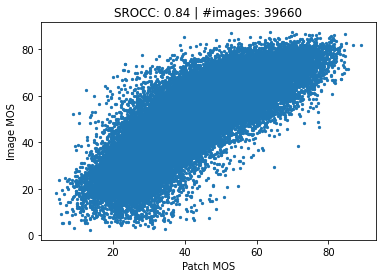

In [71]:
N = len(df_p)
patch_files = []
patch_mos = []
image_mos = []
patch_idx = []
img_idx = []
# tag = []
for i in range(N):
  p = df_p['Image'][i]
  p = p.split('/')
  # print(p)
  batch = p[0]
  patch_name = p[1]
  batch = batch.replace('_rand','')
  batch = batch.replace('_sal','')
  batch = batch.replace('_mixed','')
  patch_name = patch_name.replace('_rand','')
  patch_name = patch_name.replace('_sal','')
  img_name = batch + '/' + patch_name 

  # print(name)
  # print(vid_name)
  try:
    idx = df_c.index[df_c['Image'] == img_name].tolist()[0]
    image_mos.append(df_c['MOS'][idx])
    patch_idx.append(i)
    img_idx.append(idx)
    patch_files.append(patch_name)
    patch_mos.append(df_p['MOS'][i])
  except:
    # print(vid_name)
    continue
  # print(vid_name)


s1 = pd.Series(patch_mos)
s2 = pd.Series(image_mos)
srocc = s1.corr(s2, method='spearman')

plt.scatter(s1, s2, s=5)
plt.xlabel('Patch MOS')
plt.ylabel('Image MOS')
plt.title('SROCC: ' + str(round(srocc,2)) + ' | ' + '#images: ' + str(len(patch_files)))
plt.show()


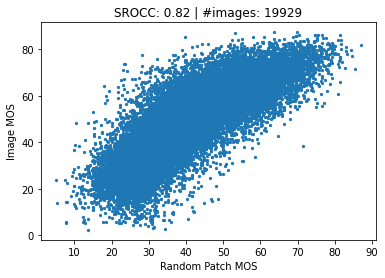

In [72]:
N = len(df_p)
patch_files = []
patch_mos = []
image_mos = []
patch_idx = []
img_idx = []
# tag = []
for i in range(N):
  p = df_p['Image'][i]
  p = p.split('/')
  # print(p)
  batch = p[0]
  patch_name = p[1]
  batch = batch.replace('_rand','')
  # batch = batch.replace('_sal','')
  batch = batch.replace('_mixed','')
  patch_name = patch_name.replace('_rand','')
  # patch_name = patch_name.replace('_sal','')
  img_name = batch + '/' + patch_name 

  # print(name)
  # print(vid_name)
  try:
    idx = df_c.index[df_c['Image'] == img_name].tolist()[0]
    image_mos.append(df_c['MOS'][idx])
    patch_idx.append(i)
    img_idx.append(idx)
    patch_files.append(patch_name)
    patch_mos.append(df_p['MOS'][i])
  except:
    # print(vid_name)
    continue
  # print(vid_name)


s1 = pd.Series(patch_mos)
s2 = pd.Series(image_mos)
srocc = s1.corr(s2, method='spearman')

plt.scatter(s1, s2, s=5)
plt.xlabel('Random Patch MOS')
plt.ylabel('Image MOS')
plt.title('SROCC: ' + str(round(srocc,2)) + ' | ' + '#images: ' + str(len(patch_files)))
plt.show()


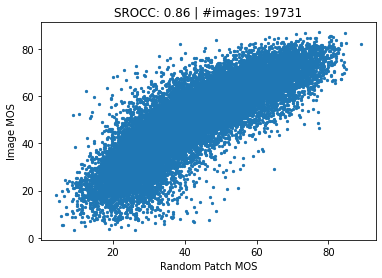

In [73]:
N = len(df_p)
patch_files = []
patch_mos = []
image_mos = []
patch_idx = []
img_idx = []
# tag = []
for i in range(N):
  p = df_p['Image'][i]
  p = p.split('/')
  # print(p)
  batch = p[0]
  patch_name = p[1]
  # batch = batch.replace('_rand','')
  batch = batch.replace('_sal','')
  batch = batch.replace('_mixed','')
  # patch_name = patch_name.replace('_rand','')
  patch_name = patch_name.replace('_sal','')
  img_name = batch + '/' + patch_name 

  # print(name)
  # print(vid_name)
  try:
    idx = df_c.index[df_c['Image'] == img_name].tolist()[0]
    image_mos.append(df_c['MOS'][idx])
    patch_idx.append(i)
    img_idx.append(idx)
    patch_files.append(patch_name)
    patch_mos.append(df_p['MOS'][i])
  except:
    # print(vid_name)
    continue
  # print(vid_name)


s1 = pd.Series(patch_mos)
s2 = pd.Series(image_mos)
srocc = s1.corr(s2, method='spearman')

plt.scatter(s1, s2, s=5)
plt.xlabel('Random Patch MOS')
plt.ylabel('Image MOS')
plt.title('SROCC: ' + str(round(srocc,2)) + ' | ' + '#images: ' + str(len(patch_files)))
plt.show()


In [80]:
def ret_dist_vec(dist):
  blr = dist.count('blurry')
  shk = dist.count('shaky')
  brt = dist.count('bright')
  drk = dist.count('dark')
  grn = dist.count('grainy')
  non = dist.count('none')
  oth = dist.count('other_')
  
  vec = np.asarray([blr,shk,brt,drk,grn,non,oth])
  return vec

In [83]:
D = []
for i in range(len(df_c)):
    dist = df_c['Distortions'][i]
    vec = ret_dist_vec(dist)
    
    D.append(vec)
    
D = np.asarray(D)

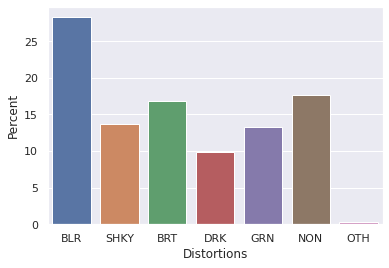

In [85]:
y = D.sum(axis=0)
# y = y[:-1]
y = 100*y/sum(y)
# print(y)
sns.set()
sns.barplot(x=['BLR','SHKY','BRT','DRK','GRN','NON','OTH'],y=y)
plt.xlabel('Distortions')
plt.ylabel('Percent')
plt.show()

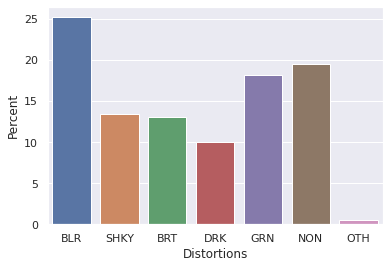

In [86]:
D = []
for i in range(len(df_o)):
    dist = df_o['Distortions'][i]
    vec = ret_dist_vec(dist)
    
    D.append(vec)
    
D = np.asarray(D)

y = D.sum(axis=0)
# y = y[:-1]
y = 100*y/sum(y)
# print(y)
sns.set()
sns.barplot(x=['BLR','SHKY','BRT','DRK','GRN','NON','OTH'],y=y)
plt.xlabel('Distortions')
plt.ylabel('Percent')
plt.show()